In [19]:
import pickle
import numpy as np
import scipy.stats as stats
import math
import json

In [20]:
model = "Qwen3-8B"

In [21]:
with open("/data/home/vkropoti/sql_data/mini-dev-index", "rb") as fp:   # Unpickling
    mini_dev_index = np.array(pickle.load(fp))
    
def load_json():
    with open('/home/vkropoti/vllm/dev.json', "r") as j:
        contents = json.loads(j.read())
    return contents

def load_split():
    data = load_json()
    query_level = []
    for k in range(len(data)):
        query_level.append(data[k]['difficulty'])
    return np.array(query_level)

In [22]:
split = load_split()

In [23]:
np.mean(split=='simple')

np.float64(0.6029986962190352)

In [24]:
np.mean(split=='moderate')

np.float64(0.30247718383311606)

In [25]:
np.mean(split=='challenging')

np.float64(0.09452411994784876)

In [26]:
def I_alpha(mean,n,std_dev,confidence = 0.95):
    # Критическое значение t для 95% ДИ и 49 степеней свободы
    t_value = stats.t.ppf((1 + confidence) / 2, df=n-1)
    margin_of_error = t_value * (std_dev / math.sqrt(n))
    
    # Границы доверительного интервала
    ci_lower = mean - margin_of_error
    ci_upper = mean + margin_of_error
    return ci_lower, ci_upper

In [27]:
def load_results(k,nobs,cot_type,think=False):
    # sql_results_Qwen3-8B-cot_all_new_think==False_nobs2-v0
    # with open(f"/data/home/vkropoti/sql_llm_answers/base_reasoning/sql_results_{model}-cot_{type_cot}_think=={use_think}-v{k}", "rb") as fp:
    with open(f"/data/home/vkropoti/sql_llm_answers/bird_dev/sql_results_Qwen3-8B-cot_{cot_type}_think=={think}_nobs{nobs}-v{k}", "rb") as fp:
        results = np.array(pickle.load(fp))
    return results

In [28]:
def load_executed(k,nobs,cot_type,think=False):
    # /data/home/vkropoti/sql_llm_answers/base_reasoning/sql_executed_{model}-cot_{type_cot}_think=={use_think}-v{version}
    with open(f"/data/home/vkropoti/sql_llm_answers/bird_dev/sql_executed_Qwen3-8B-cot_{cot_type}_think=={think}_nobs{nobs}-v{k}", "rb") as fp:
        executed = np.array(pickle.load(fp))
    return executed

In [83]:
def get_think_results(n,nobs=2,cot_type='all_new',think=False):
    
    arr_mean_scores = []
    arr_mean_executed = []
    d_split = {"simple":[], "moderate":[], "challenging":[]}
    for i in range(n):
        result, executed = load_results(i,nobs,cot_type,think), load_executed(i,nobs,cot_type,think)
        arr_mean_scores.append(np.mean(result))
        arr_mean_executed.append(np.mean(executed))
        d_split['simple'].append(np.mean(result[split=='simple']))
        d_split['moderate'].append(np.mean(result[split=='moderate']))
        d_split['challenging'].append(np.mean(result[split=='challenging']))
        
    if cot_type=='all_new':
        add = "данные о размышлениях + финальный ответ"
    elif cot_type=='think':
        add = "только данные о размышлениях"
    elif cot_type=='predict':
        add = "только данные о финальных ответах"

    ci_lower, ci_upper = I_alpha(np.mean(np.array(arr_mean_scores)),n,np.std(np.array(arr_mean_scores)))
    print(f"Модель основывает ответ по {nobs} выводам других моделей, которые включают {add}")
    print(f"Результаты получены прогоном {n} симуляций с разными seed")
    print(f"{model} DEV Финальный результат EX: {np.mean(np.array(arr_mean_scores)):.5f}, при std: {np.std(np.array(arr_mean_scores)):.4f}")
    print(f"95% доверительный интервал: ({ci_lower:.5f},{ci_upper:.5f})")
    for type_ in d_split:
        print(f"{type_}: {np.mean(np.array(d_split[type_])):.5f}")
    # print(f"{model} процент запросов, которые успешно выполнились DEV: {np.mean(np.array(arr_mean_executed)):.4f}, при std: {np.std(np.array(arr_mean_executed)):.4f}")
    return np.mean(np.array(arr_mean_scores))
    # print(f"{model} процент запросов, которые успешно выполнились Mini DEV: {np.mean(np.array(arr_mean_executed)):.4f}, при std: {np.std(np.array(arr_mean_executed)):.4f}")
    

## Использование reasoning+ответ

In [84]:
scores = []
for n in range(2,8):
    scores.append(get_think_results(20,nobs=n,cot_type='all_new'))
    print()

Модель основывает ответ по 2 выводам других моделей, которые включают данные о размышлениях + финальный ответ
Результаты получены прогоном 20 симуляций с разными seed
Qwen3-8B DEV Финальный результат EX: 0.57249, при std: 0.0035
95% доверительный интервал: (0.57086,0.57412)
simple: 0.64514
moderate: 0.47263
challenging: 0.42862

Модель основывает ответ по 3 выводам других моделей, которые включают данные о размышлениях + финальный ответ
Результаты получены прогоном 20 симуляций с разными seed
Qwen3-8B DEV Финальный результат EX: 0.57627, при std: 0.0041
95% доверительный интервал: (0.57433,0.57821)
simple: 0.64751
moderate: 0.47726
challenging: 0.43862

Модель основывает ответ по 4 выводам других моделей, которые включают данные о размышлениях + финальный ответ
Результаты получены прогоном 20 симуляций с разными seed
Qwen3-8B DEV Финальный результат EX: 0.57728, при std: 0.0045
95% доверительный интервал: (0.57517,0.57940)
simple: 0.64778
moderate: 0.47942
challenging: 0.44069

Модель 

## Использование только ответ

In [85]:
scores_predict = []
for n in range(2,8):
    scores_predict.append(get_think_results(20,nobs=n,cot_type='predict'))
    print()

Модель основывает ответ по 2 выводам других моделей, которые включают только данные о финальных ответах
Результаты получены прогоном 20 симуляций с разными seed
Qwen3-8B DEV Финальный результат EX: 0.56731, при std: 0.0056
95% доверительный интервал: (0.56470,0.56992)
simple: 0.64032
moderate: 0.46897
challenging: 0.41621

Модель основывает ответ по 3 выводам других моделей, которые включают только данные о финальных ответах
Результаты получены прогоном 20 симуляций с разными seed
Qwen3-8B DEV Финальный результат EX: 0.56972, при std: 0.0050
95% доверительный интервал: (0.56738,0.57206)
simple: 0.64211
moderate: 0.47295
challenging: 0.41759

Модель основывает ответ по 4 выводам других моделей, которые включают только данные о финальных ответах
Результаты получены прогоном 20 симуляций с разными seed
Qwen3-8B DEV Финальный результат EX: 0.57174, при std: 0.0043
95% доверительный интервал: (0.56972,0.57376)
simple: 0.64438
moderate: 0.47446
challenging: 0.41966

Модель основывает ответ п

## Использование только размышлений

In [86]:
scores_think = []
for n in range(2,8):
    scores_think.append(get_think_results(20,nobs=n,cot_type='think'))
    print()

Модель основывает ответ по 2 выводам других моделей, которые включают только данные о размышлениях
Результаты получены прогоном 20 симуляций с разными seed
Qwen3-8B DEV Финальный результат EX: 0.57422, при std: 0.0046
95% доверительный интервал: (0.57208,0.57636)
simple: 0.64881
moderate: 0.47435
challenging: 0.41793

Модель основывает ответ по 3 выводам других моделей, которые включают только данные о размышлениях
Результаты получены прогоном 20 симуляций с разными seed
Qwen3-8B DEV Финальный результат EX: 0.57696, при std: 0.0036
95% доверительный интервал: (0.57528,0.57863)
simple: 0.65054
moderate: 0.47780
challenging: 0.42483

Модель основывает ответ по 4 выводам других моделей, которые включают только данные о размышлениях
Результаты получены прогоном 20 симуляций с разными seed
Qwen3-8B DEV Финальный результат EX: 0.57819, при std: 0.0044
95% доверительный интервал: (0.57612,0.58027)
simple: 0.65103
moderate: 0.47899
challenging: 0.43103

Модель основывает ответ по 5 выводам дру

In [80]:
# get_think_results(20,nobs=6,cot_type='think')

In [81]:
# get_think_results(20,nobs=7,cot_type='think')

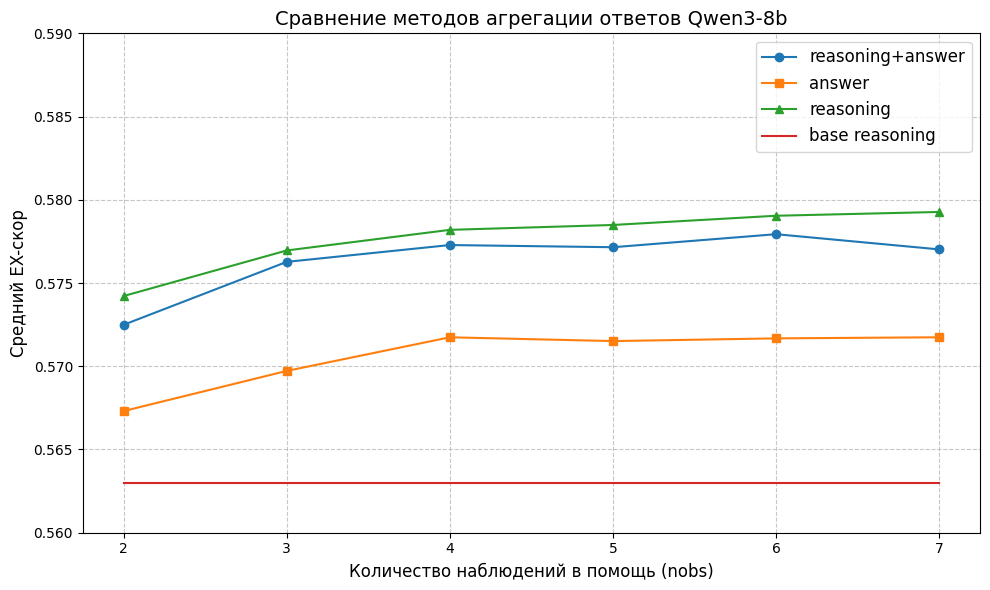

In [82]:
import matplotlib.pyplot as plt
import numpy as np

# Данные
nobs = [2, 3, 4, 5, 6, 7]
base_think = [0.569]*6
# Создание графика
plt.figure(figsize=(10, 6))
plt.plot(nobs, scores, marker='o', label='reasoning+answer', color='tab:blue')
plt.plot(nobs, scores_predict, marker='s', label='answer', color='tab:orange')
plt.plot(nobs, scores_think, marker='^', label='reasoning', color='tab:green')
plt.plot(nobs, base_think, label='base reasoning', color='tab:red')

# Настройки
plt.title('Сравнение методов агрегации ответов Qwen3-8b', fontsize=14)
plt.xlabel('Количество наблюдений в помощь (nobs)', fontsize=12)
plt.ylabel('Средний EX-скор', fontsize=12)
plt.xticks(nobs)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=12)
plt.ylim(0.56, 0.59)  # Фиксируем диапазон для лучшего сравнения

# Отображение
plt.tight_layout()
plt.show()